In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [8]:
df = pd.read_csv('shares.csv', index_col=0) # загружаем данные
df['clock'] = pd.to_datetime(df['clock']) # преобразуем в дату
df = df.resample('1d', on='clock').mean().fillna(method='ffill') # делаем ресемрлирование

In [11]:
df.head(10) # однокомпонентный временной ряд

,value
clock,
2010-01-02,237.67
2010-01-03,235.29
2010-01-04,255.61
2010-01-05,255.61
2010-01-06,229.93
2010-01-07,227.51
2010-01-08,227.51
2010-01-09,248.84
2010-01-10,250.61


Воспользуемся методом sequence-to-sequence для предсказания - будем двигаться временым окном по нашему временному ряду и делать предсказания на каждый следующий шаг

In [29]:
def seq2seq_window_ds(series, steps_before, steps_ahead, batch_size=32, shuffle_buffer=1000):
    """Функция для генерации временный окон для тренировки"""
    window_size = steps_before + steps_ahead # шаги обучения + шаг предсказания
    series = tf.expand_dims(series, axis=-1) # расширяем размерность
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=steps_ahead, drop_remainder=True) # создаем временные окна
    ds = ds.flat_map(lambda w: w.batch(window_size)) # делаем батчи временных окон
    ds = ds.shuffle(shuffle_buffer).batch(batch_size) # перемешиваем окна
    ds = ds.map(lambda window: (window[:, :-steps_ahead], window[:, steps_ahead:])) # делим каждое окно на Х и У
    return ds.prefetch(1)

def model_forecast(model, series, steps_before, steps_ahead):
    """Функция для генерации временный окон для предсказания"""
    window_size = steps_before # шаги, на которых обучались
    series = tf.expand_dims(series, axis=-1) # расширяем размерность
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=steps_ahead, drop_remainder=True) # создаем временные окна
    ds = ds.flat_map(lambda w: w.batch(window_size)) # делаем батчи временных окон
    ds = ds.batch(1).prefetch(1) # берем временное окно
    forecast = model.predict(ds) # делаем предсказание
    return forecast

def split_dataset(series, ratio=0.8):
    split_idx = int(ratio*len(series)) # индекс разбиения
    return series[:split_idx], series[split_idx:]
    
def make_train_val_sets(series, ratio, steps_before, steps_ahead, batch_size=64):
    x_train, x_valid = split_dataset(series, ratio) # разделим на train и validation
    train_set = seq2seq_window_ds(x_train, steps_before, steps_ahead, batch_size=batch_size) # формируем батчи
    valid_set = seq2seq_window_ds(x_valid, steps_before, steps_ahead, batch_size=batch_size) # формируем батчи
    return train_set, valid_set

In [39]:
def create_model(model_type=None):
    """Создаем архитектуру сети"""
    input_ = keras.Input(shape=[None, 1])
    x = keras.layers.Conv1D(filters=32, kernel_size=5,
              strides=1, padding="causal",
              activation="relu")(input_) # входной слой
    x = keras.layers.LSTM(128, recurrent_dropout=0.3, return_sequences=True)(x) # lstm слой
    x = keras.layers.LSTM(128, recurrent_dropout=0.2, return_sequences=True)(x) # lstm слой
    output_ = keras.layers.Dense(1)(x) # выходной слой
    model = keras.Model(input_, output_, name='conv_lstm')
    return model
    
def train_model(data, steps_before, steps_ahead, epochs=500):
    """Функция для тренировки модели"""
    tf.random.set_seed(42) # фиксируем случайность
    np.random.seed(42) # фиксируем случайность
    keras.backend.clear_session() # очищаем предыдушие следы модели
    
    series = data.values.ravel()
    train_set, valid_set = make_train_val_sets(series, 0.8, steps_before, steps_ahead) # формируем батчи для подачи в модель

    model = create_model() # создаем модель
    model.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=["mae"])
    # model_checkpoint = keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True) # сохраняем лучшую
    early_stopping = keras.callbacks.EarlyStopping(patience=10) # раннее прекращение
    history = model.fit(train_set, epochs=epochs,
                        validation_data=valid_set,
                        callbacks=[early_stopping], verbose=1) # сохраняем историю
    best_n = np.argmin(history.history['mae']) # лучшая модель
    best_fit = [{item[0]:np.round(item[1][best_n], 4)} for item in history.history.items()][1::2] # лучшие результаты
    return model, history, best_fit

def make_prediction(data, model, steps_before, steps_ahead):
    """Функция для выработки прогноза"""
    series = data.values
    prediction = model_forecast(model, series, steps_before, steps_ahead) # делаем предсказание
    prediction = np.array([i[-steps_ahead:] for i in prediction]).ravel() # приводжим к виду
    # компенсируем сдвиг в данных, на случай несоответствия окна и датасета
    dt = data.index[1] - data.index[0]
    prediction_idx = np.array([data.index.min() + i*dt for i in range(len(data)+steps_ahead)])
    last_idx_out = (len(data)-steps_before)%steps_ahead
    if last_idx_out == 0:
        prediction_idx = prediction_idx[steps_before:]
    else:
        prediction_idx = prediction_idx[steps_before:-last_idx_out]
    return prediction_idx, prediction, last_idx_out


In [42]:
STEPS_BEFORE = 30 # шаги тренировки
STEPS_AHEAD = 1 # шаги предсказания
epochs = 50

scl = MinMaxScaler()
train_df, test_df = split_dataset(df, ratio=0.8) # разбиение на выборки
train_df_scl = pd.DataFrame(scl.fit_transform(train_df), index=train_df.index) # масштабирование
test_df_scl = pd.DataFrame(scl.transform(test_df), index=test_df.index) # масштабирование

model, _, train_val_scores = train_model(train_df_scl, STEPS_BEFORE, STEPS_AHEAD, epochs=epochs) # тренировка модели

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp4irz_atl.py, line 6)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp4irz_atl.py, line 6)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpvaqd8um9.py, line 6)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux

40/40 [==============================] - 3s 76ms/step - loss: 0.0046 - mae: 0.0424 - val_loss: 0.0039 - val_mae: 0.0398


MAE на тестовой выборке: 5.976


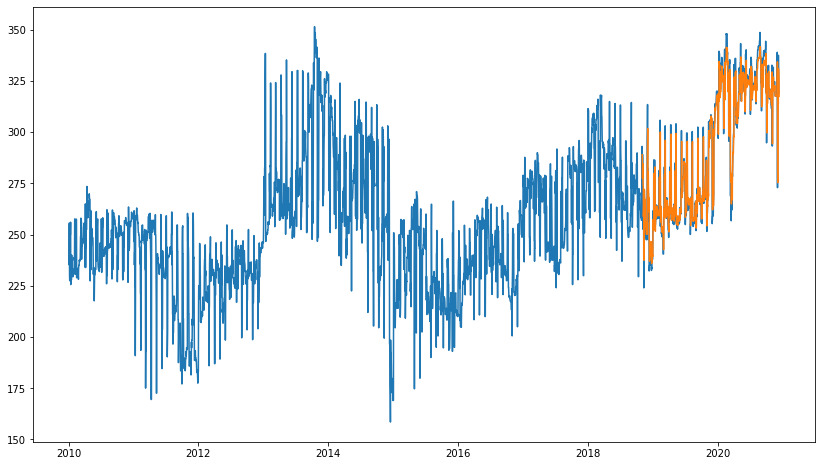

In [43]:
pred_idx, pred, idx_out = make_prediction(test_df_scl, model, STEPS_BEFORE, STEPS_AHEAD)
pred_inverse = scl.inverse_transform(np.array([i for i in pred]).reshape(-1,1)).ravel()

test_mae_json = mean_absolute_error(test_df[STEPS_BEFORE:], pred_inverse[:idx_out-STEPS_AHEAD])
print('MAE на тестовой выборке: %.3f' %test_mae_json)

plt.figure(figsize=(14,8))
plt.plot(df.index, df.values)
plt.plot(pred_idx, pred_inverse)
plt.show()